In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-03-04 12:46:29.971488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 12:46:29.971515: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_DIR = Path("../data")
ORIGINAL_DATA_SUBDIR = Path("Pepsico RnD Potato Lab Dataset")
TRAIN_SUBDIR = Path("Train")
TEST_SUBDIR = Path("Test")
MODELS_DIR = Path("../models")

In [3]:
image_size = (256, 256)
batch_size = 16

In [4]:
train_dataset = keras.utils.image_dataset_from_directory(DATA_DIR / ORIGINAL_DATA_SUBDIR / TRAIN_SUBDIR, batch_size=batch_size, image_size=image_size, validation_split=0.2, subset="training", seed=7)
validation_dataset = keras.utils.image_dataset_from_directory(DATA_DIR / ORIGINAL_DATA_SUBDIR / TRAIN_SUBDIR, batch_size=batch_size, image_size=image_size, validation_split=0.2, subset="validation", seed=7)
test_dataset = keras.utils.image_dataset_from_directory(DATA_DIR / ORIGINAL_DATA_SUBDIR / TEST_SUBDIR, batch_size=batch_size, image_size=image_size)

Found 769 files belonging to 2 classes.
Using 616 files for training.
Found 769 files belonging to 2 classes.
Using 153 files for validation.
Found 192 files belonging to 2 classes.


2022-03-04 12:46:31.566738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-04 12:46:31.566768: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-04 12:46:31.566787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ali-HP-EliteBook-840-G4): /proc/driver/nvidia/version does not exist
2022-03-04 12:46:31.567111: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


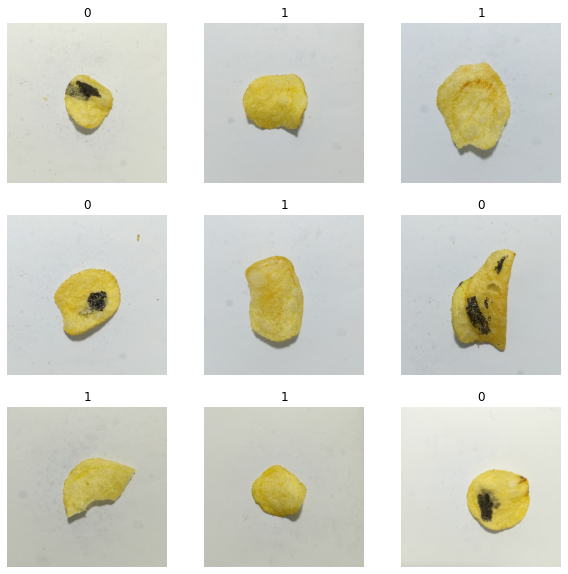

In [5]:
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
model = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0

In [7]:
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

In [8]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(MODELS_DIR / "my_best_model.keras", save_best_only=True)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset
)

Epoch 1/10
39/39 [==============================] - 33s 750ms/step - loss: 0.7610 - accuracy: 0.6250 - val_loss: 0.4822 - val_accuracy: 0.9346
Epoch 2/10
39/39 [==============================] - 32s 769ms/step - loss: 0.3981 - accuracy: 0.8604 - val_loss: 0.2464 - val_accuracy: 0.9216
Epoch 3/10
39/39 [==============================] - 35s 841ms/step - loss: 0.2008 - accuracy: 0.9399 - val_loss: 0.0816 - val_accuracy: 0.9804
Epoch 4/10
39/39 [==============================] - 30s 714ms/step - loss: 0.0898 - accuracy: 0.9756 - val_loss: 0.0419 - val_accuracy: 0.9935
Epoch 5/10
39/39 [==============================] - 32s 771ms/step - loss: 0.0891 - accuracy: 0.9789 - val_loss: 0.0545 - val_accuracy: 0.9804
Epoch 6/10
39/39 [==============================] - 30s 711ms/step - loss: 0.0867 - accuracy: 0.9724 - val_loss: 0.0460 - val_accuracy: 0.9804
Epoch 7/10
39/39 [==============================] - 30s 716ms/step - loss: 0.0377 - accuracy: 0.9903 - val_loss: 0.0299 - val_accuracy: 0.9935

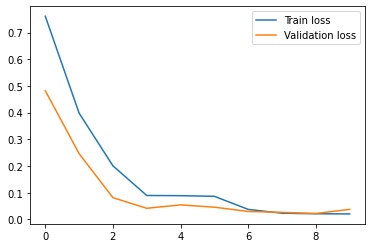

In [9]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]
plt.plot(range(len(train_loss)), train_loss, label = "Train loss")
plt.plot(range(len(valid_loss)), valid_loss, label = "Validation loss")
plt.legend()

In [10]:
model = keras.models.load_model(MODELS_DIR / "my_best_model.keras")

In [16]:
score = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]*100:.2f}%")

Test loss: 0.04746728762984276
Test accuracy: 97.92%
